In [1]:
import numpy as np
import matplotlib.pyplot as plt

import py4DSTEM
print(py4DSTEM.__version__)

C:\ProgramData\Miniconda3\envs\stem_images\Lib\site-packages\paramiko\pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\Miniconda3\envs\stem_images\Lib\site-packages\paramiko\transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


0.14.15


In [2]:
import phase_STEM as ps

In [3]:
import dask.array as da

## Load data, basic visualization

In [3]:
path = "C:/Users/yuxi8598/Documents/STEM image simulations/Structures/SrTiO3/4DSTEM_simulations/64px/frames/"

In [4]:
filespath = ps.io.find_files(path, '.dat')
len(filespath)

4096

In [5]:
# given the data type is np.float32
npimg = np.fromfile(filespath[0], dtype=np.float32)
npimg.shape

(20736,)

In [6]:
sizex = np.sqrt(20736)
sizex

144.0

In [209]:
%matplotlib qt5

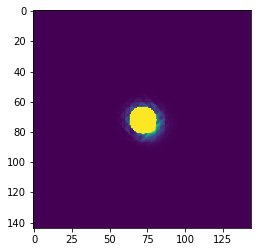

In [7]:
npimg = npimg.reshape(144,144)
plt.imshow(npimg, vmax=1e-3)

In [149]:
%matplotlib qt5
profile = ps.tools.line_intensity_profile(npimg, "rochgraphm", resolution=1, width=3, length_unit='nm', zoom_in = False)

In [8]:
frames = np.zeros((4096, 144,144))
for i, file in enumerate(filespath):
    npimg = np.fromfile(file, dtype=np.float32)
    frames[i] = npimg.reshape(144,144)

In [9]:
frames = frames.reshape(64,64,144,144)

In [10]:
frames.shape

(64, 64, 144, 144)

In [11]:
pacbed = np.average(frames, axis=(0,1))

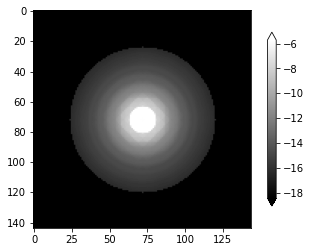

In [20]:
fig, ax = plt.subplots()
p1 = ax.imshow(np.log(pacbed+1e-8), cmap='grey')
fig.colorbar(p1, ax=ax, shrink=0.8, extend='both')

In [21]:
%matplotlib inline
ps.tools.find_radius(pacbed, center=None, mask_size=None)

interactive(children=(FloatText(value=72.0, description='center X:', step=0.1), FloatText(value=72.0, descript…

In [22]:
center = (72,72)

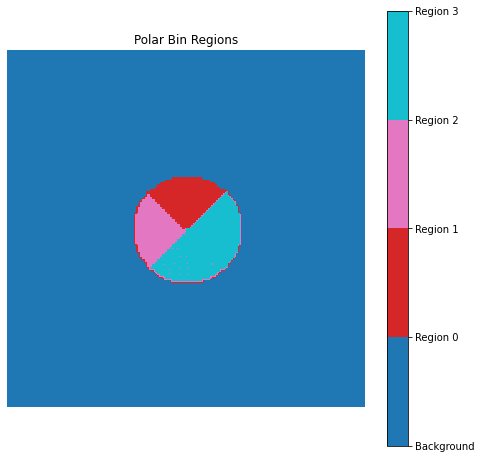

In [23]:
semi_conv = 15 # mrad
radius_probe = 9.7*2 # pixels
pixel_size_Q = radius_probe/semi_conv # pixel/mrad
inner_radius = 0 * pixel_size_Q # pixel
outer_radius = 17 * pixel_size_Q # pixel
nbins_radial = 1 
nbins_azimuthal = 4

detectors = ps.tools.segmented_circular_masks(mask_size = [144,144], 
                                 nbins_radial = nbins_radial, 
                                 nbins_azimuthal = nbins_azimuthal, 
                                 center = center, 
                                 inner_radius = inner_radius, 
                                 outer_radius = outer_radius, 
                                 rotation = np.pi/4)


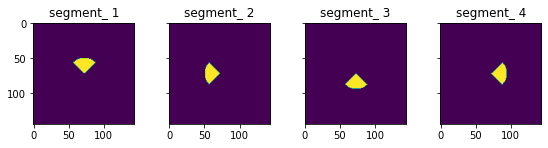

In [24]:
fig, axes = plt.subplots(nbins_radial, nbins_azimuthal, figsize =(2*nbins_azimuthal, 2*nbins_radial), sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(detectors[i], cmap = 'viridis')
    ax.set_title(f'segment_ {i+1}')
    ax.axis('on')
plt.tight_layout()
plt.show()

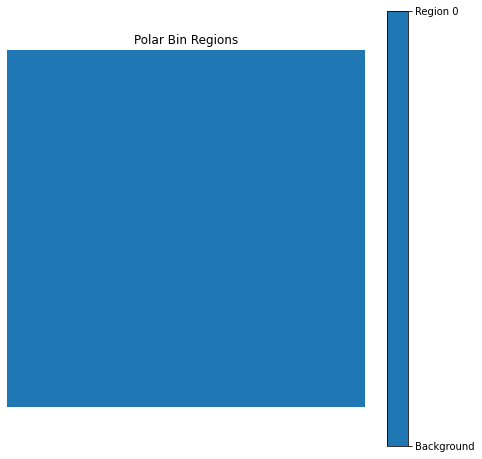

In [27]:
ADF_det = ps.tools.segmented_circular_masks(mask_size = [144,144], 
                                 nbins_radial = 1, 
                                 nbins_azimuthal = 1, 
                                 center = center, 
                                 inner_radius = 15 * pixel_size_Q, 
                                 outer_radius = 15 * pixel_size_Q *3, 
                                 rotation = 0)

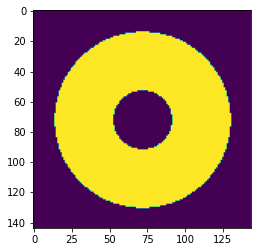

In [28]:
plt.imshow(ADF_det[0])

Extracting intensities: 100%|██████████| 64/64 [00:00<00:00, 155.35row/s]


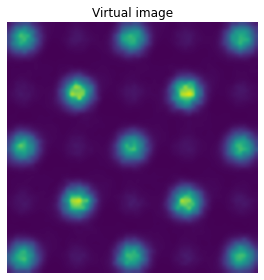

In [29]:
ADF = ps.tools.COMProcessor(frames, center=center, nbins_radial = 1, nbins_azimuthal=1, rotation=0, device='cpu') 
adfimage, _ = ADF.segment_intensities(15 * pixel_size_Q, 15 * pixel_size_Q *3)
ADF.visualize(plot='segments') 

Extracting intensities: 100%|██████████| 64/64 [00:00<00:00, 153.48row/s]


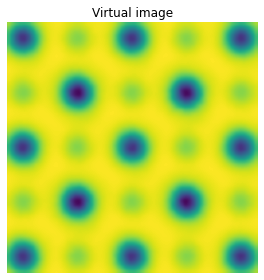

In [30]:
bfimage, _ = ADF.segment_intensities(0, 15 * pixel_size_Q)
ADF.visualize(plot='segments') 

Extracting intensities: 100%|██████████| 64/64 [00:00<00:00, 88.89row/s]


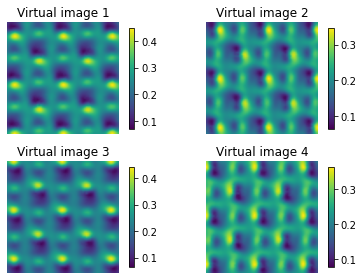

In [31]:
DPC = ps.tools.COMProcessor(frames, center=center, nbins_radial = nbins_radial, nbins_azimuthal=nbins_azimuthal, rotation=np.pi/4, device='cpu') 
segs, coms = DPC.segment_intensities(inner_radius, outer_radius)
DPC.visualize(plot='segments') 

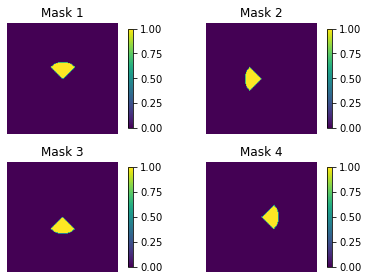

In [114]:
DPC.visualize(plot='masks') 

In [33]:
Cy = segs[0] - segs[2]
Cx = segs[3] - segs[1]

In [146]:
cal_idpc = ps.analysis.Noniterate_iDPCBuilder(Cx, Cy, epsilon = 1e-3)

In [147]:
# For our Themis Z machine, the rotation angle is about 88 (or 44) degrees, and it needs to flip (flip the directions of x- and y-axis)
# If you use A-C for CoMx and B-D for CoMy, then the angle is 88 degrees.

theta_1, flip_1 = cal_idpc.optimize_rotation(Cx, Cy, thetas = np.arange(-180, 180, 1), epsilon = 1e-3)

Calculating:   0%|          | 0/720 [00:00<?, ?iteration/s]

It is needed to preserve the intensity
Does it need to flip: False
The rotation angle is: -92.00 degrees


In [148]:
idpc = cal_idpc.run(theta_1, flip_1, expanding=True)

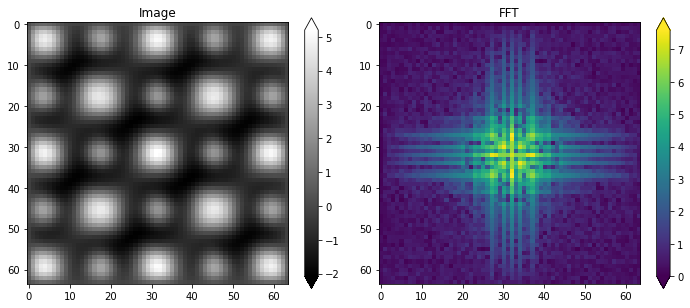

In [149]:
ps.tools.plot_fft(-idpc, log=True, names='iDPC')

In [39]:
# you also can use coms[0], coms[1] instead of Cx, Cy
fm = ps.analysis.Noniterate_FMBuilder(coms[0], coms[1], epsilon=1e-2, mask=None)
#t1, f1 = fm.optimize_rotation(Cx, Cy, thetas = np.arange(-180, 180, 1), epsilon = 1e-2)
t1, f1 = fm.optimize_rotation(coms[0], coms[1], thetas = np.arange(-180, 180, 1), epsilon = 1e-2)

Calculating:   0%|          | 0/720 [00:00<?, ?iteration/s]

It is needed to preserve the intensity
Does it need to flip: True
The rotation angle is: 0.00 degrees


In [42]:
fmstem = fm.run(t1, f1, expanding=True)

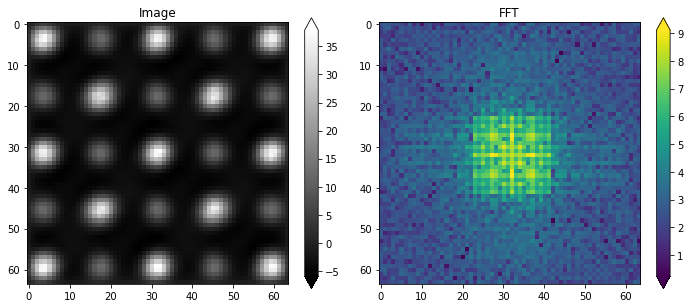

In [43]:
ps.tools.plot_fft(fmstem, log=True, names='FM-STEM')

In [44]:
resolution = 0.014062 # nm per pixel

In [45]:
wavelength = ps.analysis.wavelength_beam(300)

In [46]:

parameters = {"sample thickness(nm)": 20,
             "wavelength(nm)": wavelength,
             "pixel size(nm)": resolution,
              "dose rate(e-Å-2)": 1,
             "collection angles(rad)": [0.00, 0.034], 
             "semi_convergence angle(rad)": 0.015,
             "pixelnumber of filters": segs[0].shape[0], #controlling the pixel size of the filter
             "virtual grids in one segment detector": 30}

In [84]:
detector_range = np.array(([45,135], [135,225], [225,315], [-45,45]), dtype = np.float64)

In [77]:
# Firstly, we need the aberrations measured by probe Cs-corrector
#Adopting the notations supplied by Uhlemann and Haider

ab = {        'C1': -2.1,                       #defocus (over focus negative), a real value
              'A1': 1.8 + 1j*np.radians(-56.31),     #Two-fold astigamastism
              'B2': 16.9 + 1j*np.radians(-51.23),    #Axial coma, a complex, here using the result measured by Sherpa
              'A2': 0 + 1j*np.radians(0),         #Three-fold astigmatism
              'C3': 0,                                #Spherical aberration
              'A3': 0 + 1j*np.radians(0),          #Four-fold astigmatism
              'S3': 0 + 1j*np.radians(0),          #Axial star aberration
              'A4': 0 + 1j*np.radians(0)}

In [85]:
#built_WPO = ps.analysis.phase_filters_GPU(ab, segments, parameters, slices=[False, 20], single_side_band=False, process=True)

built_WPO, num = ps.analysis.phase_filters_GPU(ab, detector_range, parameters, slices=1, process=True)

Building:   0%|           [ time left: ? ]

--- 4 seconds left!
The whole process takes 18 seconds.


In [86]:
wpo = []
for i in built_WPO:
    wpo.append(i/num)

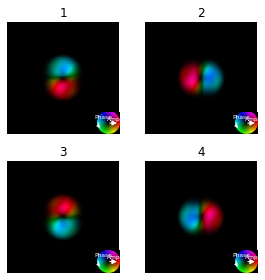

In [87]:
ps.tools.plot_vector_image(wpo, title=['1', '2', '3', '4'], imgsize = 4, storing = [False, 'path_save'])

In [115]:
# it is tricky that the sequence of segmented images is not the same as that of frequency filters
# compared to the segmented images shown before, we know the correct sequence should be like as below:
images = [segs[0], segs[3], segs[2], segs[1]]

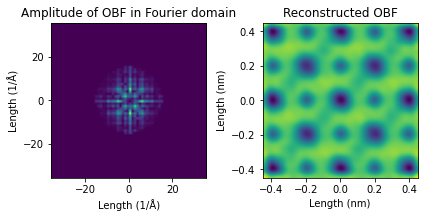

In [116]:
Builder= ps.analysis.OBFBuilder(images, wpo, parameters)
OBF_img, OBF_Q= Builder.reconstruct_OBF(upsampling=0)

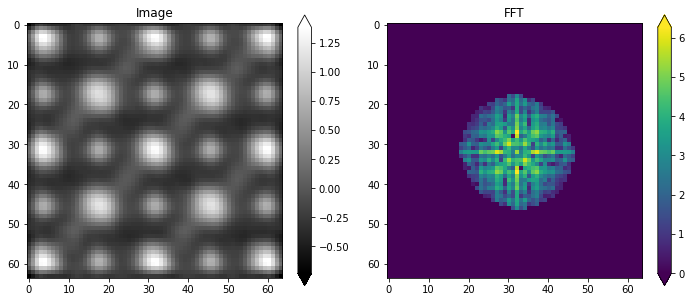

In [117]:
# reality

obf_ft= np.real(np.fft.ifft2(np.fft.fftshift(np.sum(OBF_Q, axis=0))))
ps.tools.plot_fft(-obf_ft, log=True, names='OBF')

In [131]:
from matplotlib_scalebar.scalebar import ScaleBar

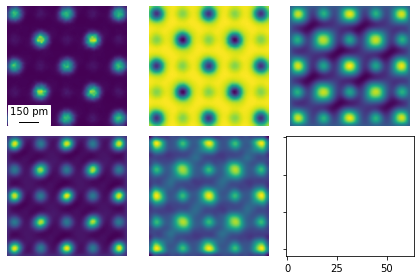

In [150]:
fig, axes = plt.subplots(2,3, figsize =(6,4), sharex=True, sharey=True)
phase_images = [adfimage[0], bfimage[0], -idpc, fmstem, -OBF_img]
for i, ax in enumerate(axes.ravel()):
    if i < 5:
        pcm = ax.imshow(phase_images[i], cmap = 'viridis', interpolation = 'gaussian')
        ax.axis('off')  
        if i ==0:
            scale_bar = ScaleBar(
            resolution, 
            units='nm', 
            dimension='si-length', # si-length-reciprocal
            length_fraction=0.2, 
            location='lower left', 
            scale_loc='top'
            )
            ax.add_artist(scale_bar)
plt.tight_layout()
#plt.savefig(f"{path}/Nb2O5_2.tiff")
plt.show()

## 1. COM analysis (from py4DSTEM's tutorial)
#### In DPC, we measure the center of mass (CoM) of the electron probe in diffraction space for each probe position. This CoM corresponds to the average in-plane momentum of the electron beam, which is proportional to the electic field. In matter, the electric field is the derivative of the sample's electrostatic potential, which in turn is proportional to the sample's phase shift. Hence if we numerically integrate the signal, we can reconstruct the phase.

#### We first estimate the relative rotation between the real space scanning coordinate system and the diffraction space detector coordinates. This value can be non-zero if the STEM scan coils are rotated to some angle, if the detector is rotated around the optical axis, or if the data has been read incorrectly (transposing x and y or kx and ky for example).

#### A good recosntruction will show the CoMx has dipoles along the x, while the CoMy has dipoles in the y direction.

#### We will reconstruct the DPC with a mask to select only the bright field disk to remove spurious signals from diffracted disks that can bias the results in this small field of view.

In [119]:
import py4DSTEM

In [120]:
dataset = py4DSTEM.DataCube(
    data=frames
)
dataset

DataCube( A 4-dimensional array of shape (64, 64, 144, 144) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [122]:
dataset.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (144, 144) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

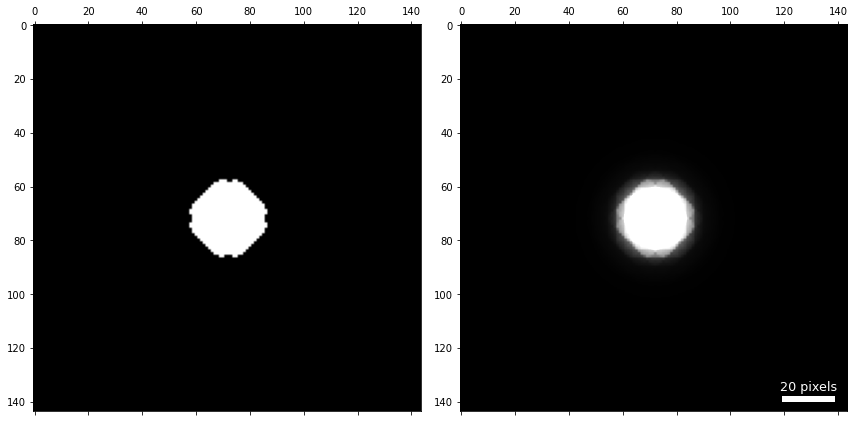

In [124]:
### create mask for bright field disk
dp_mask = dataset.tree('dp_mean').data>1e-4
py4DSTEM.show(
    [
        dp_mask,
        dataset.tree('dp_mean'),
    ]
)

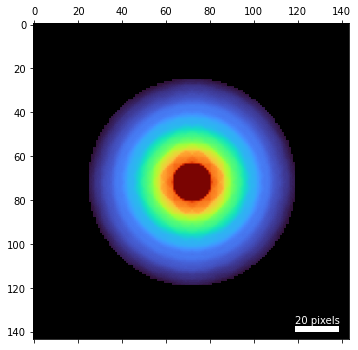

In [125]:
py4DSTEM.show(
    dataset.tree('dp_mean'),
    scaling = 'log',
    cmap = 'turbo',
)

Iterative reconstruction will not be quantitative unless you specify real-space calibrations in 'A'
Iterative reconstruction will not be quantitative unless you specify appropriate reciprocal-space calibrations
Best fit rotation = 0 degrees.


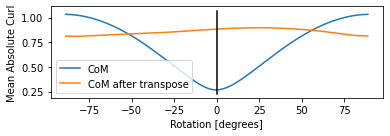

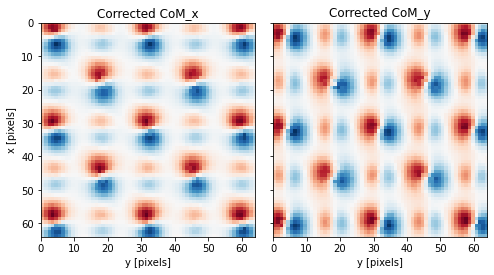

In [126]:
#it computes the (qx_shift, qy_shift) momentum vector estimate for all probe positions. 
#It is accomplished by computing the first moment of the intentisty distribution in the x and y directions.

dpc = py4DSTEM.process.phase.DPC(
    datacube=dataset,
    energy=300e3,
).preprocess(dp_mask = dp_mask)

In [127]:
dpc._rotation_best_rad #unit: radians

0.0

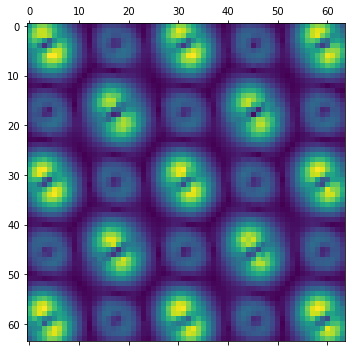

In [128]:
# Plot the electric field magnitude of the sample, from the CoM gradients.
py4DSTEM.show(
    np.linalg.norm([dpc._com_x, dpc._com_y], axis=0),
    cmap='viridis',
    vmin=0,
    vmax=0.999,
)

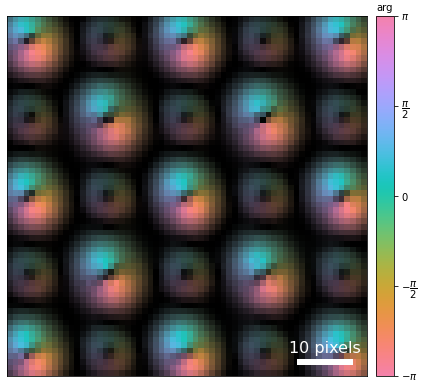

In [129]:
#complex_com = comx + 1j*comy
dpc.show_complex_CoM(vmin=0, vmax=0.99)

Reconstructing phase:  61%|██████    | 39/64 [00:00<00:00, 1770.09 iter/s]
Step-size has decreased below stopping criterion 1e-06.


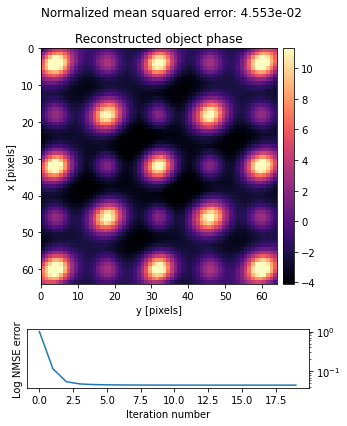

In [130]:
dpc=dpc.reconstruct().visualize()

Reconstructing phase: 100%|██████████| 32/32 [00:00<00:00, 1597.66 iter/s]


DPC( A Node called 'dpc_reconstruction', containing the following top-level objects in its tree:

)

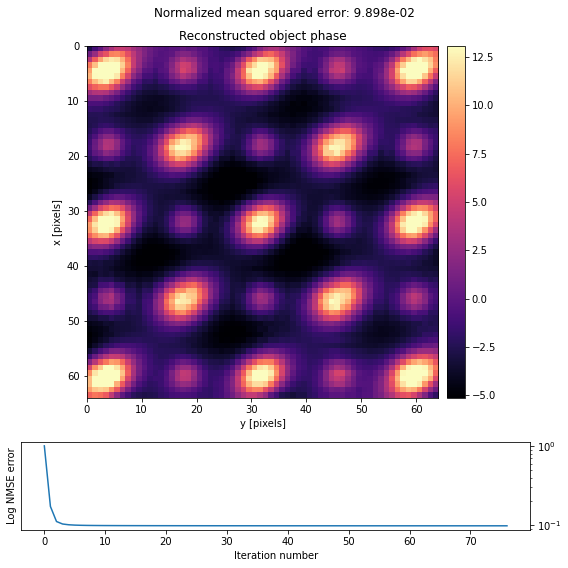

In [33]:
dpc.reconstruct(
    max_iter=32,
    stopping_criterion = 1e-07,
    reset = False,
    gaussian_filter_sigma = 0.1, #in pixel since it hasn't been calibrated
).visualize(
    figsize=(8,8),
    cbar=True,
)

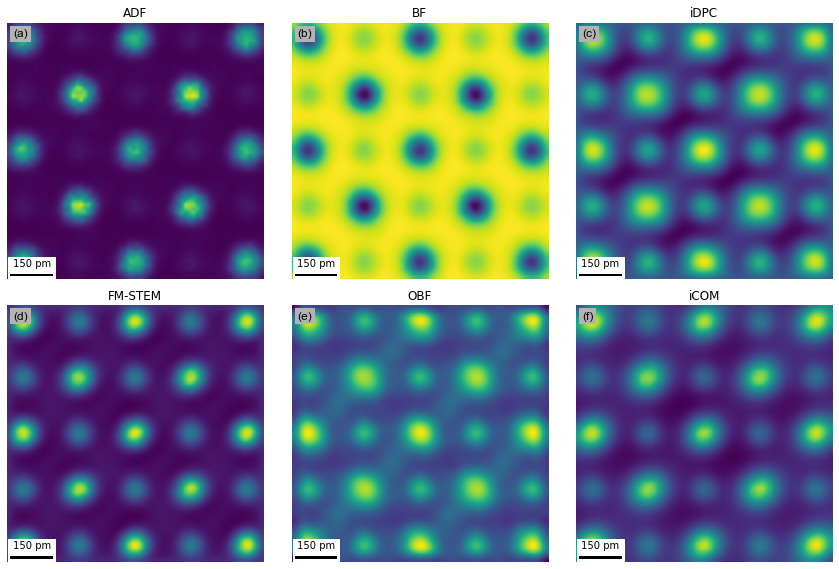

In [151]:
# As the "idpc" is cp.array, if you want to plot is using 'matplotlib', then you should convert it into np.array
#We can use the following commander to plot/save the 'idpc'

ps.tools.plot_image([adfimage[0], bfimage[0], -idpc, fmstem, -OBF_img, dpc._object_phase], properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'',
             'image titles': ['ADF','BF','iDPC', 'FM-STEM', 'OBF', 'iCOM'],
             'figsize':4,
              'cmap':'viridis',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [64,64], [45,45]],
             'saving image': False,   # if you want to save it, then 'True'
             'saving path':path+ "/fm_obf3"  # choose the saving folder address and the name of this figure
              })

## 2. Single-slice reconstruction

In [34]:
#semi_convergence angle of probe is 15 mrad
# At 300 keV, the wavelength is 0.01967 Angstroms.  
q_probe = (15/1000) / 0.01967 #manually determine the pixel size in diffraction space
# Now we can estimate the sampling using our semiangles in pixels:
k_sampling = q_probe / probe_semiangle
# giving:
print('Diffraction space pixel size = ' + str(np.round(k_sampling, decimals=3)) + ' 1/Å')

Diffraction space pixel size = 0.041 1/Å


### Calibration

In [35]:
Q_pixel_size = 0.851927 # 1/nm per pixel


In [36]:
dataset.calibration.set_R_pixel_size(10*0.9/64)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(0.851927)
dataset.calibration.set_Q_pixel_units('mrad')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.851927
             R_pixel_size:    0.140625
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

In [126]:
#  bin the data due to the close zero defocus, and therefore has a small spatial extent.
# pad the data because the step size is smaller than the maximum real space sampling
# implied by k_max in diffraction space.
bin_factor = 2
pad_factor = 2
dataset_bin_pad = dataset.copy()
dataset_bin_pad.bin_Q(bin_factor)
dataset_bin_pad.pad_Q(pad_factor)

DataCube( A 4-dimensional array of shape (64, 64, 144, 144) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,2,4,...] pixels
              Qy = [0,2,4,...] pixels
)

In [127]:
#calibrations
dataset_bin_pad.calibration.set_Q_pixel_size(k_sampling*bin_factor)
dataset_bin_pad.calibration.set_Q_pixel_units('A^-1')
dataset_bin_pad.calibration.set_R_pixel_size(0.140625) # Å per scanning step, that is the pixel size in R-space
dataset_bin_pad.calibration.set_R_pixel_units('A')
dataset_bin_pad.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.031829796722243314
             R_pixel_size:    0.140625
             Q_pixel_units:   A^-1
             R_pixel_units:   A
             QR_flip:         False
)

In [ ]:
%matplotlib inline

Best fit rotation forced to 0 degrees.
Transpose of intensities forced to False.
Normalizing amplitudes: 100%|██████████| 4096/4096 [00:00<00:00, 7086.89probe position/s]


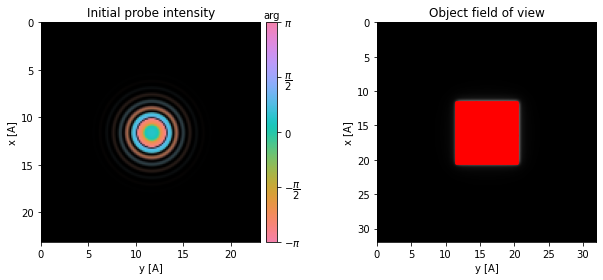

In [37]:
singleslice = py4DSTEM.process.phase.SingleslicePtychography(
    datacube = dataset,
    verbose=True,
    energy=300e3,
    semiangle_cutoff=15, # Semiangle cutoff for the initial probe guess in mrad
    defocus = 24
).preprocess(plot_center_of_mass = False,
            force_com_rotation = 0,
           force_com_transpose = False )

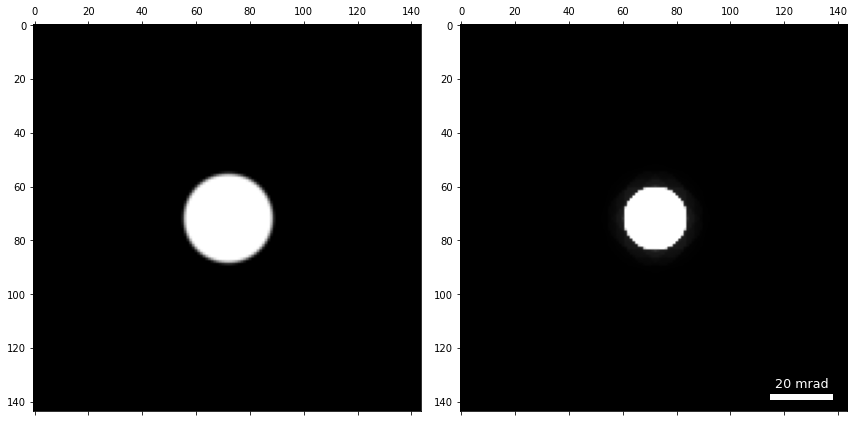

In [39]:
py4DSTEM.show(
    [np.abs(singleslice.probe_fourier), dataset.get_dp_mean()]
)

Performing 30 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.5.
Reconstructing object and probe: 100%|██████████| 30/30 [07:25<00:00, 14.86s/ iter]


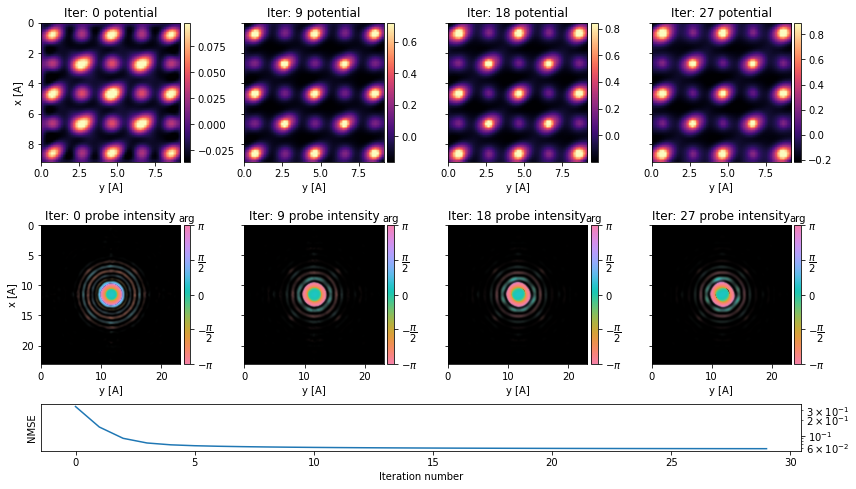

In [60]:
singleslice = singleslice.reconstruct(
    reset = True,
    progress_bar = True,
    store_iterations = True,
    num_iter = 30,
    pure_phase_object = True,
    step_size = 0.5,
    fix_probe=False,
).visualize(iterations_grid = 'auto')

In [56]:
ptycho_iter = singleslice.object_iterations
print(len(ptycho_iter))

30


SingleslicePtychography( A Node called 'ptychographic_reconstruction', containing the following top-level objects in its tree:

)

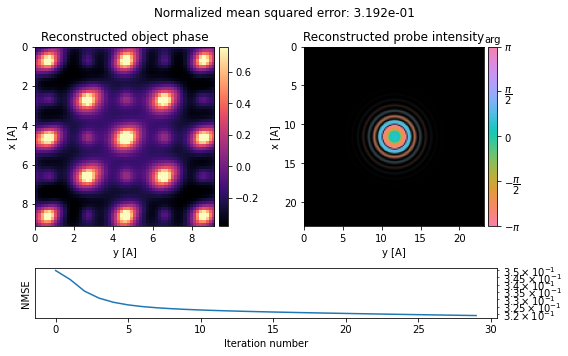

In [57]:
singleslice.visualize()

In [58]:
complex_object_fix = singleslice.object

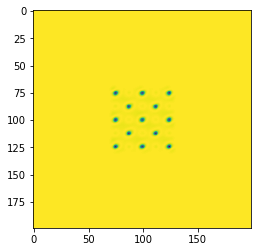

In [59]:
plt.imshow(complex_object.real)

Shape of object: (57, 57)
(Min,Max) Amplitude: (1.0,1.0)


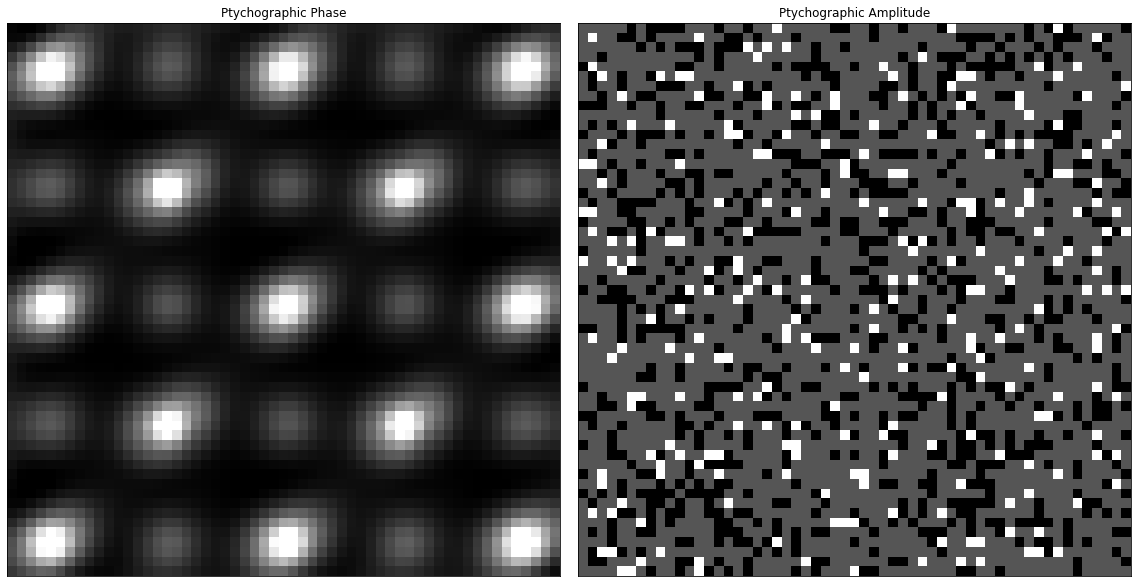

In [46]:
# Let's take a closer look at the phase reconstruction:
obj = singleslice.object_cropped
print("Shape of object:", obj.shape)
print(f'(Min,Max) Amplitude: ({np.abs(obj).min():.4},{np.abs(obj).max():.4})')

py4DSTEM.show(
    [
        np.angle(obj),
        np.abs(obj),
    ],
    title = ['Ptychographic Phase', 'Ptychographic Amplitude'],
    ticks=False,
    axsize=(8,8),
)

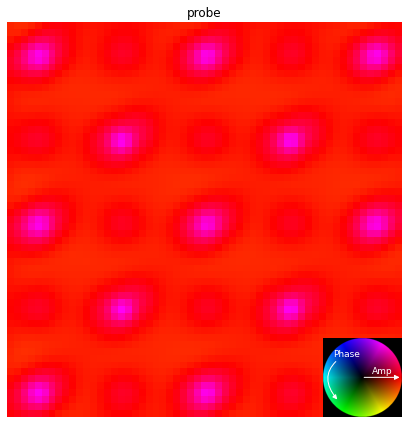

In [49]:
ps.tools.plot_vector_image(obj_create, title=['probe'], imgsize = 6, storing = [False, 'path_save'])

In [48]:
obj_create = np.abs(obj)*np.exp(-1j*np.angle(obj))

In [195]:
%matplotlib qt5
profile = ps.tools.line_intensity_profile(dpc.object_phase, "phase", resolution=1, width=3, length_unit='nm', zoom_in = False)

In [51]:
import h5py

In [257]:
ptycho_iter = singleslice.object_iterations
print("The iteration is :", len(ptycho_iter))

The iteration is : 10


In [52]:

with h5py.File(save_path +'reconstructions_singleslice_20mrad.h5', 'w') as f:
    f.create_dataset('bright_field image', data=dataset.tree('bright_field').data)
    f.create_dataset('ADF_image(1-3times', data=dataset.tree('annular dark field').data)
    f.create_dataset('ptychographic phase', data = np.angle(obj))
    f.create_dataset('ptychographic amplitude', data = np.abs(obj))
    f.create_dataset('iCOM', data = dpc._object_phase)
    for p in range(len(ptycho_iter)):
        f.create_dataset('iterative'+str(p), data=np.angle(ptycho_iter[p]))
f.close()

In [282]:
ptycho_iter[4].shape

(199, 199)

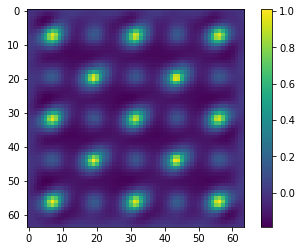

In [53]:
%matplotlib inline
plt.imshow(np.angle(singleslice.object)[100-32:100+32, 100-32:100+32])
plt.colorbar()

In [54]:

with h5py.File(save_path +'reconstructions_singleslice_object20mrad.h5', 'w') as f:
    f.create_dataset('ptychography_object', data=singleslice.object)
f.close()